In [1]:
import pandas as pd
import pandas_datareader.data as pdr
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from keras.layers import LSTM

Using TensorFlow backend.


In [2]:
import fix_yahoo_finance as fix
fix.pdr_override()

In [3]:
class GetData:
    def __init__(self, ticker, start, end, interval):
        self.ticker = ticker
        self.start = start
        self.end = end
        self.interval = interval

    # get stock data
    def get_stock_data(self):
        stock_data = pdr.get_data_yahoo(self.ticker, self.start, self.end, self.interval)
        stock_data.to_csv("stock_data.csv")

    # get twitter data
    # do your code here!

    # get news data
    # do your code here!


if __name__ == "__main__":
    data = GetData("^DJI", "2015-04-01", "2019-05-03", "60m")
    data.get_stock_data()



[*********************100%***********************]  1 of 1 downloaded


In [4]:
df = pd.read_csv("stock_data.csv")

In [5]:
print(df.head())

         Date      Open      High       Low     Close  Adj Close     Volume  \
0  2015-03-31  17965.37  17965.37  17773.02  17776.12   17776.12  119470000   
1  2015-04-01  17778.52  17778.52  17585.01  17698.18   17698.18  103360000   
2  2015-04-02  17699.52  17815.03  17673.49  17763.24   17763.24   87370000   
3  2015-04-06  17755.50  17941.79  17646.80  17880.85   17880.85  100850000   
4  2015-04-07  17884.32  17983.12  17871.21  17875.42   17875.42   72150000   

   Dividends  Stock Splits  
0          0             0  
1          0             0  
2          0             0  
3          0             0  
4          0             0  


In [6]:
df.drop(['Open', 'High', 'Low', 'Close', 'Volume', 'Dividends', 'Stock Splits'], axis=1, inplace=True)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1030 entries, 0 to 1029
Data columns (total 2 columns):
Date         1030 non-null object
Adj Close    1030 non-null float64
dtypes: float64(1), object(1)
memory usage: 16.2+ KB


In [8]:
df['Date'] = pd.to_datetime(df['Date'])

In [9]:
df = df.set_index(['Date'], drop=True)

In [10]:
df.head(10)

,Adj Close
Date,
2015-03-31,17776.12
2015-04-01,17698.18
2015-04-02,17763.24
2015-04-06,17880.85
2015-04-07,17875.42
2015-04-08,17902.51
2015-04-09,17958.73
2015-04-10,18057.65
2015-04-13,17977.04


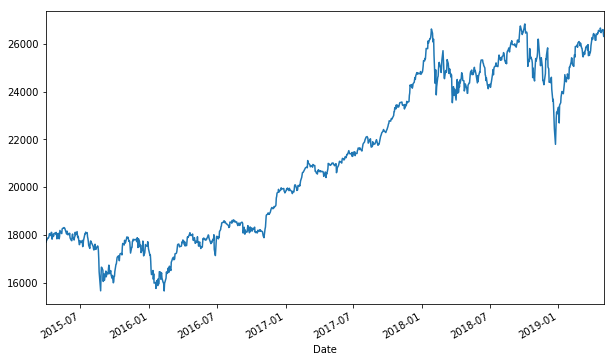

In [11]:
# df = df.sort_index()
plt.figure(figsize=(10, 6))
df['Adj Close'].plot();

In [12]:
split_date = pd.Timestamp('2018-07-01')

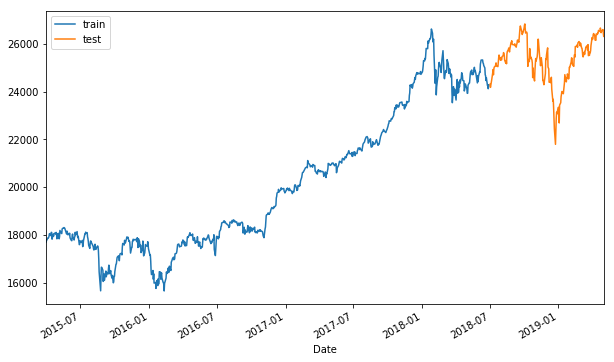

In [13]:
df =  df['Adj Close']
train = df.loc[:split_date]
test = df.loc[split_date:]
plt.figure(figsize=(10, 6))
ax = train.plot()
test.plot(ax=ax)
plt.legend(['train', 'test']);

In [14]:
# scale train and test data to [-1, 1]
scaler = MinMaxScaler(feature_range=(-1, 1))
train_sc = scaler.fit_transform(train.values.reshape(-1, 1))
test_sc = scaler.transform(test.values.reshape(-1, 1))

In [15]:
X_train = train_sc[:-1]
y_train = train_sc[1:]

X_test = test_sc[:-1]
y_test = test_sc[1:]

## NN

In [16]:
nn_model = Sequential()
nn_model.add(Dense(12, input_dim=1, activation='relu'))
nn_model.add(Dense(1))
nn_model.compile(loss='mean_squared_error', optimizer='adam')
early_stop = EarlyStopping(monitor='loss', patience=2, verbose=1)
history = nn_model.fit(X_train, y_train, epochs=100, batch_size=10, verbose=1, callbacks=[early_stop], shuffle=False)

Epoch 1/100
819/819 [==============================] - 1s 2ms/step - loss: 0.1245
Epoch 2/100
819/819 [==============================] - 0s 301us/step - loss: 0.0320
Epoch 3/100
819/819 [==============================] - 0s 293us/step - loss: 0.0087
Epoch 4/100
819/819 [==============================] - 0s 410us/step - loss: 0.0051
Epoch 5/100
819/819 [==============================] - 0s 351us/step - loss: 0.0046
Epoch 6/100
819/819 [==============================] - 0s 275us/step - loss: 0.0043
Epoch 7/100
819/819 [==============================] - 0s 275us/step - loss: 0.0041
Epoch 8/100
819/819 [==============================] - 0s 350us/step - loss: 0.0039
Epoch 9/100
819/819 [==============================] - 0s 286us/step - loss: 0.0038
Epoch 10/100
819/819 [==============================] - 0s 278us/step - loss: 0.0036
Epoch 11/100
819/819 [==============================] - 0s 312us/step - loss: 0.0034
Epoch 12/100
819/819 [==============================] - 0s 273us/step - loss

In [17]:
y_pred_test_nn = nn_model.predict(X_test)
y_train_pred_nn = nn_model.predict(X_train)
print("The R2 score on the Train set is:\t{:0.3f}".format(r2_score(y_train, y_train_pred_nn)))
print("The R2 score on the Test set is:\t{:0.3f}".format(r2_score(y_test, y_pred_test_nn)))

The R2 score on the Train set is:	0.995
The R2 score on the Test set is:	0.919


## LSTM

In [18]:
train_sc_df = pd.DataFrame(train_sc, columns=['Y'], index=train.index)
test_sc_df = pd.DataFrame(test_sc, columns=['Y'], index=test.index)

for s in range(1,2):
    train_sc_df['X_{}'.format(s)] = train_sc_df['Y'].shift(s)
    test_sc_df['X_{}'.format(s)] = test_sc_df['Y'].shift(s)

X_train = train_sc_df.dropna().drop('Y', axis=1)
y_train = train_sc_df.dropna().drop('X_1', axis=1)

X_test = test_sc_df.dropna().drop('Y', axis=1)
y_test = test_sc_df.dropna().drop('X_1', axis=1)

X_train = X_train.values
y_train = y_train.values

X_test = X_test.values
y_test = y_test.values

In [19]:
X_train_lmse = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test_lmse = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

print('Train shape: ', X_train_lmse.shape)
print('Test shape: ', X_test_lmse.shape)

Train shape:  (819, 1, 1)
Test shape:  (209, 1, 1)


In [20]:
lstm_model = Sequential()
lstm_model.add(LSTM(7, input_shape=(1, X_train_lmse.shape[1]), activation='relu', kernel_initializer='lecun_uniform', return_sequences=False))
lstm_model.add(Dense(1))
lstm_model.compile(loss='mean_squared_error', optimizer='adam')
early_stop = EarlyStopping(monitor='loss', patience=2, verbose=1)
history_lstm_model = lstm_model.fit(X_train_lmse, y_train, epochs=100, batch_size=10, verbose=1, shuffle=False, callbacks=[early_stop])

Epoch 1/100
819/819 [==============================] - 5s 7ms/step - loss: 0.3573
Epoch 2/100
819/819 [==============================] - 1s 971us/step - loss: 0.2987
Epoch 3/100
819/819 [==============================] - 1s 1ms/step - loss: 0.2414
Epoch 4/100
819/819 [==============================] - 1s 1ms/step - loss: 0.1844
Epoch 5/100
819/819 [==============================] - 1s 905us/step - loss: 0.1304
Epoch 6/100
819/819 [==============================] - 1s 1ms/step - loss: 0.0839
Epoch 7/100
819/819 [==============================] - 1s 1ms/step - loss: 0.0489
Epoch 8/100
819/819 [==============================] - 1s 1ms/step - loss: 0.0265
Epoch 9/100
819/819 [==============================] - 1s 1ms/step - loss: 0.0140
Epoch 10/100
819/819 [==============================] - 1s 1ms/step - loss: 0.0081
Epoch 11/100
819/819 [==============================] - 1s 1ms/step - loss: 0.0056
Epoch 12/100
819/819 [==============================] - 1s 916us/step - loss: 0.0045
Epoch 1

819/819 [==============================] - 1s 950us/step - loss: 0.0010
Epoch 00099: early stopping


In [21]:
y_pred_test_lstm = lstm_model.predict(X_test_lmse)
y_train_pred_lstm = lstm_model.predict(X_train_lmse)
print("The R2 score on the Train set is:\t{:0.3f}".format(r2_score(y_train, y_train_pred_lstm)))
print("The R2 score on the Test set is:\t{:0.3f}".format(r2_score(y_test, y_pred_test_lstm)))

The R2 score on the Train set is:	0.994
The R2 score on the Test set is:	0.928


In [22]:
nn_test_mse = nn_model.evaluate(X_test, y_test, batch_size=1)
lstm_test_mse = lstm_model.evaluate(X_test_lmse, y_test, batch_size=1)
print ('Test Data Summary')
print('NN   --> MSE: %f'%nn_test_mse, "------- R2 score:\t{:0.3f}".format(r2_score(y_test, y_pred_test_nn)))
print('LSTM --> MSE: %f'%lstm_test_mse, "------- R2 score:\t{:0.3f}".format(r2_score(y_test, y_pred_test_lstm)))

209/209 [==============================] - 1s 5ms/step
Test Data Summary
NN   --> MSE: 0.002284 ------- R2 score:	0.919
LSTM --> MSE: 0.002053 ------- R2 score:	0.928


In [23]:
nn_y_pred_test = nn_model.predict(X_test)
lstm_y_pred_test = lstm_model.predict(X_test_lmse)

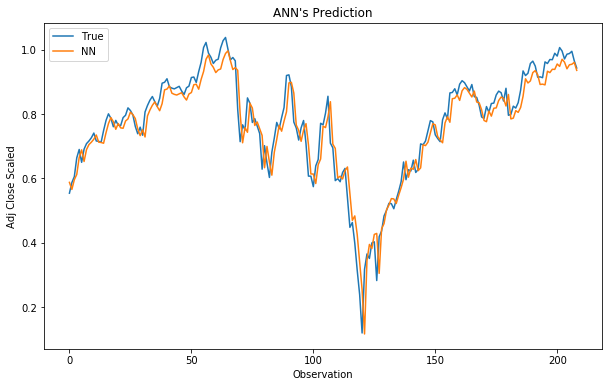

In [24]:
plt.figure(figsize=(10, 6))
plt.plot(y_test, label='True')
plt.plot(y_pred_test_nn, label='NN')
plt.title("ANN's Prediction")
plt.xlabel('Observation')
plt.ylabel('Adj Close Scaled')
plt.legend()
plt.show();

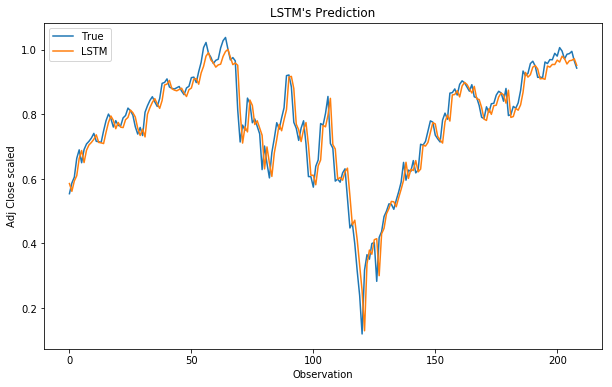

In [25]:
plt.figure(figsize=(10, 6))
plt.plot(y_test, label='True')
plt.plot(y_pred_test_lstm, label='LSTM')
plt.title("LSTM's Prediction")
plt.xlabel('Observation')
plt.ylabel('Adj Close scaled')
plt.legend()
plt.show();